In [15]:
import json
import logging
import requests
import io
import base64
from collections import defaultdict
import pandas as pd

import csv
from papermage_components.materials_recipe import MaterialsRecipe
from papermage_components.constants import MAT_IE_TYPES

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
recipe = MaterialsRecipe(
        matIE_directory="",
        grobid_server_url="http://windhoek.sp.cs.cmu.edu:8070",
    )

INFO:MaterialsRecipe:Instantiating recipe...


GROBID server is up and running


INFO:iopath.common.file_io:URL https://www.dropbox.com/s/ukbw5s673633hsw/publaynet-tf_efficientdet_d0.pth.tar?dl=1 cached in /home/guannant/.torch/iopath_cache/s/ukbw5s673633hsw/publaynet-tf_efficientdet_d0.pth.tar?dl=1
INFO:timm.models._helpers:Loaded state_dict from checkpoint '/home/guannant/.torch/iopath_cache/s/ukbw5s673633hsw/publaynet-tf_efficientdet_d0.pth.tar?dl=1'
/opt/anaconda/anaconda3/envs/papermage/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda/anaconda3/envs/papermage/lib/python3.11/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]
INFO:MaterialsRecipe:Finished instantiating recipe


In [4]:
# recipe = MaterialsRecipe(
#                         NER_model_dir = "/Users/sireeshgururaja/src/MatIE/model", # the directory of the NER model 
#                         vocab_dir  = "/Users/sireeshgururaja/src/MatIE/vpack_mat", # the directory of the vocabulary 
#                         output_folder = "data/AM_Creep_Papers_parsed_test/", # the directory of the vocabulary
#                         gpu_id = "0", 
#                         decode_script = "/Users/sireeshgururaja/src/MatIE/decode.sh", # the decode module
#                         dpi=300
# )

In [5]:
pdf_filename = "/home/guannant/Documents/ht_max/data/On the creep performance of the Ti‐6Al‐4V alloy processed by additive manufacturing.pdf"
parsed_doc, img_list = recipe.from_pdf(pdf_filename)

INFO:MaterialsRecipe:Parsing document...


INFO:MaterialsRecipe:Getting Reading Order Sections...
INFO:MaterialsRecipe:Rasterizing document...
INFO:MaterialsRecipe:Predicting words...
INFO:MaterialsRecipe:Predicting sentences...
INFO:MaterialsRecipe:Predicting blocks...
100%|██████████| 15/15 [00:02<00:00,  6.18it/s]
INFO:MaterialsRecipe:Predicting vila...
INFO:MaterialsRecipe:Predicting table structure


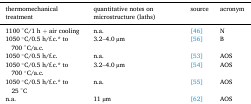

In [13]:
img_list[5]

In [27]:
def encode_image(pil_image):
    buffer = io.BytesIO()
    pil_image.save(buffer, format='PNG')
    buffer.seek(0)
    image_bytes = buffer.read()
    encoded_image = base64.b64encode(image_bytes).decode('utf-8')
    return encoded_image

def find_non_empty_indices(lst):
    return [index for index, value in enumerate(lst) if value != ""]
# Function to parse TSV data
def parse_caption_note(latex_input):
    parts = latex_input.split(r'\begin{tabular}')
    caption = parts[0].strip()
    post_table_content = parts[-1].split(r'\end{tabular}')[-1].strip()
    return caption, post_table_content

def parse_tsv(tsv_string):
    # Read the TSV data
    reader = csv.reader(tsv_string.splitlines(), delimiter='\t')
    
    # Extract headers
    headers = next(reader)
    
    # Extract rows
    rows = []
    for row in reader:
        if "" in row:
            idx_list = find_non_empty_indices(row)
            if "" == row[0]:
                for num in idx_list:
                    rows[-1][num] += row[num]
            elif len(idx_list) == 1:
                for num in idx_list:
                    rows[-1][num] += row[num]
            else:
                rows.append(row)
        else:
            rows.append(row)
    
    return headers, rows

# Function to convert parsed table to JSON
def convert_mathpix_to_json(tsv_string,latex_input):
    headers, rows = parse_tsv(tsv_string)
    #table_caption, side_notes = parse_caption_note(latex_data)
    merged_dict = defaultdict(list)
    for row in rows:
        for header, value in zip(headers, row):
            merged_dict[header].append(value)
    full_table = {}
    #full_table["caption"] = table_caption
    #full_table["notes"] = side_notes
    full_table["table_dict"] = dict(merged_dict)
    return full_table

def get_mathpix_input(encoded_image):
    json_data = {
        "src": f"data:image/jpeg;base64,{encoded_image}",
        "formats": ["text", "data"],
        "data_options": {
            "include_tsv": True,
        }
    }
    return json_data

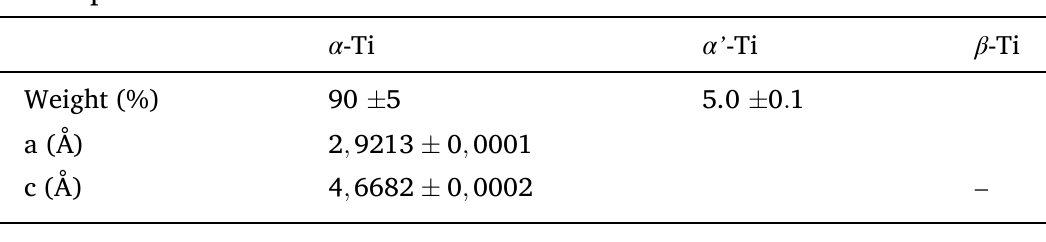

In [31]:
img_list[0]

In [7]:
math_pix_input = get_mathpix_input(encode_image(img_list[0]))
url = 'https://api.mathpix.com/v3/text'
headers = {
  "app_id": "",
  "app_key": ""
}
response = requests.post(url, headers=headers, json=math_pix_input)

In [28]:
response_data = response.json()
tsv_data = response_data["data"][0]["value"]
latex_data = response_data["text"]
json_data = convert_mathpix_to_json(tsv_data,latex_data)

In [13]:
response_data["text"]

'\\begin{tabular}{llll}\n\\hline & \\( \\alpha-\\mathrm{Ti} \\) & \\( \\alpha^{\\prime}-\\mathrm{Ti} \\) & \\( \\beta-\\mathrm{Ti} \\) \\\\\n\\hline Weight (\\%) & \\( 90 \\pm 5 \\) & \\( 5.0 \\pm 0.1 \\) & \\\\\na (Å) & \\( 2,9213 \\pm 0,0001 \\) & & - \\\\\n\\( \\mathrm{c}(\\mathrm{A}) \\) & \\( 4,6682 \\pm 0,0002 \\) & & \\\\\n\\hline\n\\end{tabular}'

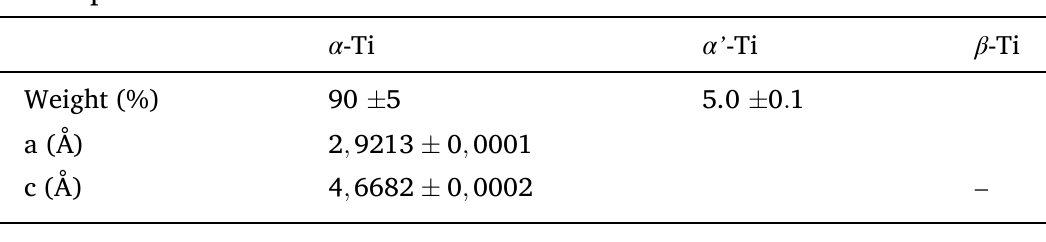

In [19]:
img_list[0]

In [29]:
pd.DataFrame(json_data["table_dict"])

,,alpha-Ti,alpha^(')-Ti,beta-Ti
0,Weight (%),90+-5,5.0+-0.1,
1,a (Å),"2,9213+-0,0001",,-
2,c(A),"4,6682+-0,0002",,


In [49]:
def get_box_image(table_box, doc: Document, page_image=None):
    box = table_box
    if page_image is None:
        page_image = doc.pages[box.page].images[0].pilimage
    page_w, page_h = page_image.size
    table_image = page_image.crop(
        (
            box.l * page_w,
            box.t * page_h,
            (box.l + box.w) * page_w,
            (box.t + box.h) * page_h,
        )
    )
    return table_image

In [57]:
spac_search = parsed_doc.tables[5].spans[0]
potential_captions = doc.find(query=spac_search, name="captions")

[Span[32429, 32777]]

In [58]:
parsed_doc.captions[5]

Annotated Entity:	ID: 5	Spans: True	Boxes: True	Text: Fig. 6. Representative TEM microstructure of the SLM after creep VLE550 a), CLE600, b), CLE650, c). Micrograph insets are indexed SAEDPs showing α ’ , β , twinned α ’ , and related crystallographic orientations. SAEDPs showing the typical crystal relationship between the residual β -platelets and the newly formed α ’ lamellar
martensite colonies within the α -phase occurring at 500/160 during fast SLM cooling is reported in d).

In [88]:
caption[0].spans[0].start

24802

In [90]:
min(abs(caption[0].spans[0].start-table4.spans[0].end),abs(caption[0].spans[0].end-table4.spans[0].start))

1

In [91]:
caption[0].id

6

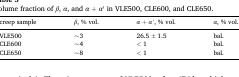

In [81]:
from papermage import Box, Document, Entity, TablesFieldName
table4 = parsed_doc.tables[4]
def get_nearby_captions(table, doc, expansion_factor):
    box = table.boxes[0]

    exp_h = expansion_factor * box.h
    diff_h = exp_h - box.h

    search_box = Box(l=box.l, t=box.t - diff_h / 2, w=box.w, h=exp_h, page=box.page)
    potential_captions = doc.find(query=search_box, name="captions")

    return get_box_image(search_box,parsed_doc), potential_captions

img,caption = get_nearby_captions(table4,parsed_doc,2)
img

In [5]:
with open(pdf_filename.replace("AM_Creep_Papers", "AM_Creep_Papers_parsed").replace(".pdf", ".json"), "w") as f:
  json.dump(parsed_paper.to_json(), f, indent=4)

In [6]:
parsed_paper.tables[0].metadata

Metadata({'label': 'Table', 'text': 'α -Ti\nα ’ -Ti\nβ -Ti\nWeight (%)\n90 ± 5\n5.0 ± 0 . 1\na (Å)\n2 , 9213 ± 0 , 0001\nc (Å)\n4 , 6682 ± 0 , 0002\n–', 'cell_boxes': [[0.5295328624535838, 0.11177179221275, 0.07872594846851737, 0.010506384152166788, 2], [0.5295328624535838, 0.1236847392013724, 0.07872594846851737, 0.0137889606056075, 2], [0.5295328624535838, 0.13851767601068615, 0.07872594846851737, 0.011871183365403238, 2], [0.5295328624535838, 0.1514547443733085, 0.07872594846851737, 0.010287747273566213, 2], [0.6203411697558894, 0.11177179221275, 0.1351353618801721, 0.010506384152166788, 2], [0.6203411697558894, 0.1236847392013724, 0.1351353618801721, 0.0137889606056075, 2], [0.6203411697558894, 0.13851767601068615, 0.1351353618801721, 0.011871183365403238, 2], [0.6203411697558894, 0.1514547443733085, 0.1351353618801721, 0.010287747273566213, 2], [0.7695139327423797, 0.11177179221275, 0.09897136203899637, 0.010506384152166788, 2], [0.7695139327423797, 0.1236847392013724, 0.098971362